# Exercise 3 - Group 08 (Academic Year 2022-2023)

- Erica Brisigotti (2097202)
- Ekaterina Chueva (2072050)
- Sofia Pacheco Garcia (2070771)
- Nadillia Sahputra (2070770)

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
import pandas as pd
import seaborn as sns

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [9]:
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 600   D= 3


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [10]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

569.5269005085432
mean minimum distance between points:  23.321029500210265


## t-SNE visualization, for true labels

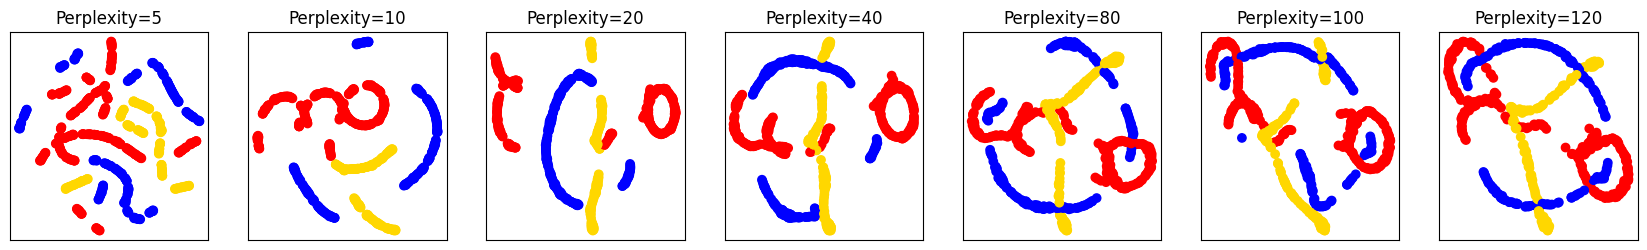

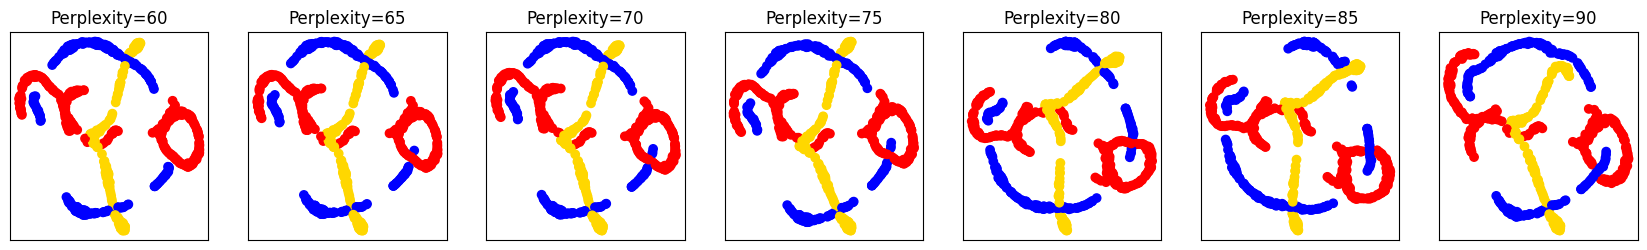

In [11]:
np.random.seed(0)
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

def my_perplexity_plot(perplexities):
    Np = len(perplexities)
    (fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))
    X_all = [None]
    for i, perplexity in enumerate(perplexities):
        ax = subplots[i]
        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(data)
        t1 = time()
        ax.set_title("Perplexity=%d" % perplexity)
        ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all.append(Y)
    plt.show()
        
my_perplexity_plot([5, 10, 20, 40, 80, 100, 120])
my_perplexity_plot([60,65,70,75,80,85,90])

A good range of perplexity is [60,90], with particularly good performance at around 80, since the points that are close in the 3-dimensional space remain close to each other, while the ones that are further apart are kept at a distance.

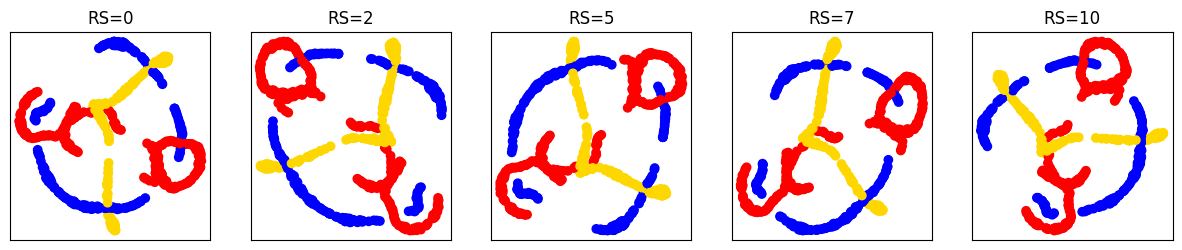

In [12]:
np.random.seed(0)
n_samples = N
n_components = 2
perplexity = 80
mycmap = ListedColormap(["blue","red","gold" ])
rs = [0, 2, 5, 7, 10]
nrs = len(rs)
(fig, subplots) = plt.subplots(1,nrs , figsize=(3*nrs, 2.7))
X_all = [None]
for i, rand_st in enumerate(rs):
    ax = subplots[i]
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',                         
                         random_state=rand_st, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("RS=%d" % rand_st)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)    
plt.show()

We then vary the the random state inizialization: different inizializations could give different local minima of the cost function and could therefore lead to different results if the algorithm isn't stable enough.
Instead, we obtained very similar shapes of the classificated data, which appear to differ from each other by rotation or reflection. We deduce that the choice of algorithm (particularly of the Kurlback Leiver entropy minimization) is very effective since it converges every time to the same absolute minimum (looking beyond the rotations and reflections).

## DBSCAN: find labels by applying clustering

In [13]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[3] # best visualization above
X = data
y_true = y

if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)

def nmi_dataframe (eps_d,eps_u,eps_step,samp_d,samp_u,samp_step):
    eps_range = np.arange(eps_d,eps_u,eps_step)
    eps_range = [float(x) for x in eps_range]
    min_sample_range = np.arange(samp_d,samp_u,samp_step)
    nmi_df = pd.DataFrame(index=eps_range, columns=min_sample_range)


    for i, eps in enumerate(eps_range):
        for j, min_samples in enumerate(min_sample_range):
            model = DBSCAN(eps=eps, min_samples=min_samples)
            model.fit(X)
            y_hat = model.labels_
            nmi=NMI(y_hat, y_true)
            nmi_df.loc[eps,min_samples] = nmi
    return nmi_df



[Text(50.722222222222214, 0.5, 'eps'),
 Text(0.5, 23.52222222222222, 'min_samples')]

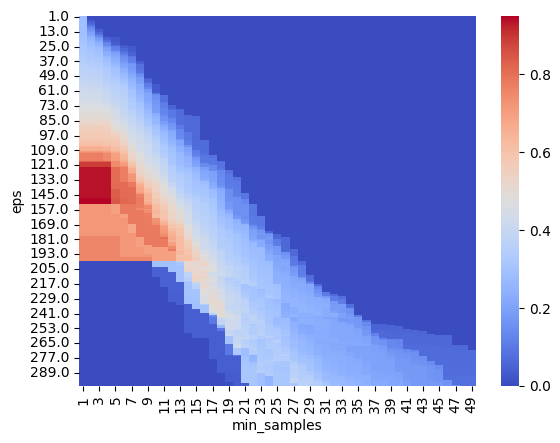

In [14]:
nmi_df = nmi_dataframe(eps_d=1, eps_u=300, eps_step=1, samp_d=1, samp_u=50, samp_step=1)
nmi_df =nmi_df.astype(float)
fig = sns.heatmap(nmi_df, cmap='coolwarm', annot=False, fmt='.2f')
fig.set(ylabel ='eps',xlabel = 'min_samples')

We observe that maximum performance is achieved for:
- eps (maximum distance between two samples to be considered as in the neighborhood of the other) in range [110,150]
- min_samples (number of sample that must be in a neighborhood of a point to be considered a core point) in range [0,5].

Other correlation trends appear as:
- an area of better performance just below one of the diagonals (top-left to bottom-right) of the plot: this can be interpreted as a general direct proportionality of eps and min_samples. Among these level lines, the most accurates estimates correspond to lower min_sample values, which connect to the aforementioned area of maximum-performance.
- two areas of low accuracy when one of the two quantities is very small and the other very big: in both extremes, the algorithm fails to distinguish multiple structures and returns just one cluster